In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-classification/WELFake_Dataset.csv


![](https://images.unsplash.com/photo-1636188540036-1879f679c2b0?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2061&q=80)

Picture source Unsplash : https://images.unsplash.com/photo-1636188540036-1879f679c2b0?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2061&q=80

## Summary
<font size = 3.5>(WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training. </font> <br><br>
<font size = 3.5>
Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).</font>

[1. EDA](#eda) <br>

[2. Prepare Input](#prepare_input)<br>

- [2.1 Tokenization](#tokenization)<br>
- [2.2 Pad sequences to fixed lenght](#sequences)<br>

[3. Train and Evaluate](#train_evaluate)<br>

- [3.1 Define the Model](#define_model)<br>
- [3.2 Train the Model](#train_model)<br>
- [3.3 Evaluate the Model](#evaluate_model)<br>
    
[4. Conclusion](#conclusion)<br> 
    


In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

import tensorflow as tf

import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split 
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import collections

from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import seaborn as sns


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
SEED = 10

In [3]:
df = pd.read_csv('../input/fake-news-classification/WELFake_Dataset.csv')
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']

X = df['text']
y = df['label']

<a id = 'eda'></a>
## 1. EDA

In [4]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Distribution of Fake - 0 /Real - 1 News')

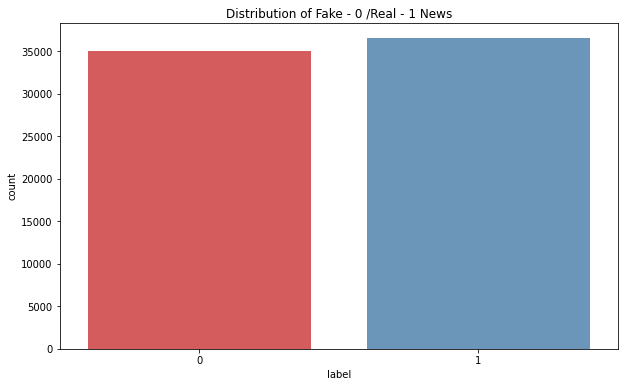

In [5]:
plt.figure(figsize = (10,6))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News')

Text(0.5, 1.0, 'Distribution of the News Words count')

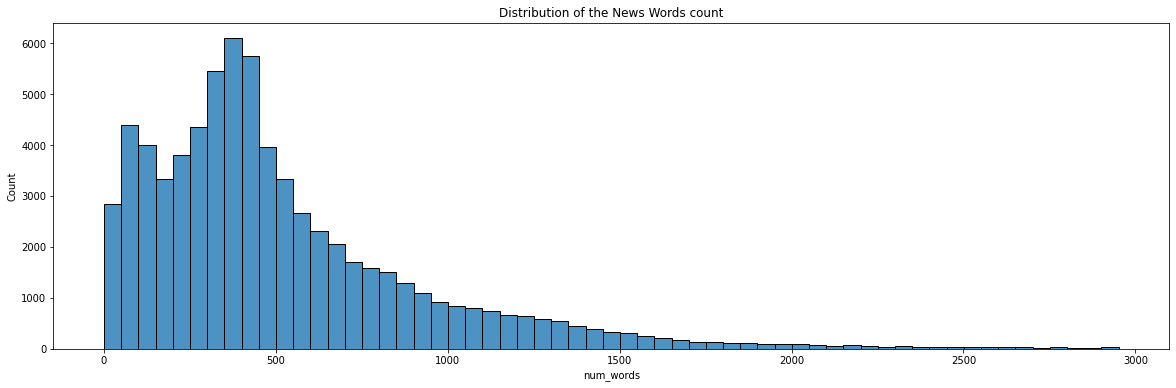

In [6]:
plt.figure(figsize = (20,6))
sns.histplot(df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the News Words count')

In [7]:
#get word collections for real/fake news
#fake_news_words = collections.Counter([word for sentence in df.loc[df['label'] == 0]['text'] for word in sentence.split()])
#real_news_words = collections.Counter([word for sentence in df.loc[df['label'] == 1]['text'] for word in sentence.split()])
# df_mc_fake = pd.DataFrame(columns = ['word','count'], data=(fake_news_words.most_common(20)))
# df_mc_real = pd.DataFrame(columns = ['word','count'], data=(fake_news_words.most_common(20)))

# fig, axes = plt.subplots(1,2,figsize = (15, 6))

# sns.barplot(data = df_mc_fake, x= 'word', y = 'count', color = '#dd0000', alpha = 0.8, ax = axes[0])
# #axes[0].tickparams(axis = 'x', rotation = 90)
# sns.barplot(data = df_mc_real, x= 'word', y = 'count', color = '#0000dd', alpha = 0.8, ax = axes[1])

<a id = 'prepare_input'></a>
## 2. Preparing the input

In [8]:
#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = SEED)

<a id = 'tokenization'></a>
## 2.1 Tokenization 

In [9]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 285418


<a id = 'sequences'></a>
## 2.2 Pad sequences to fixed lenght

In [10]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)

In [11]:
X_train_seq.shape[1]

512

<a id = 'train_evaluate'></a>
## 3. Train and evaluate the Keras LSTM model

<a id = 'define_model'></a>
## 3.1 Define the model

In [12]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 32),
    Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(16)),
    Dense(16, activation='sigmoid'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 32)           9133376   
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 64)           16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 9,160,929
Trainable params: 9,160,929
Non-trainable params: 0
______________________________________________

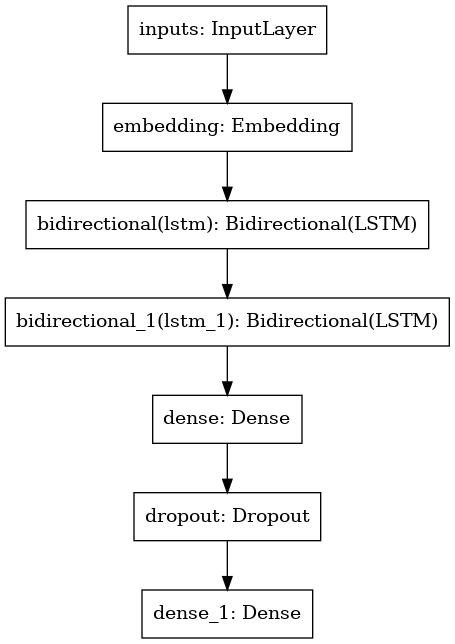

In [13]:
#plot the model architecture
tf.keras.utils.plot_model(model)

<a id = 'train_model'></a>
## 3.2 Training the model

<i><font size = 3.5>We will use a validation split of 20% during the training</font></i>

In [14]:
history = model.fit(X_train_seq, y_train, epochs=10,
                    validation_split = 0.2, batch_size = 32, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/10
1342/1342 [==============================] - 113s 78ms/step - loss: 0.5199 - accuracy: 0.7529 - val_loss: 0.2787 - val_accuracy: 0.9364
Epoch 2/10
1342/1342 [==============================] - 104s 78ms/step - loss: 0.2545 - accuracy: 0.9315 - val_loss: 0.1809 - val_accuracy: 0.9522
Epoch 3/10
1342/1342 [==============================] - 104s 77ms/step - loss: 0.1708 - accuracy: 0.9644 - val_loss: 0.1377 - val_accuracy: 0.9629
Epoch 4/10
1342/1342 [==============================] - 104s 77ms/step - loss: 0.1306 - accuracy: 0.9776 - val_loss: 0.1271 - val_accuracy: 0.9668
Epoch 5/10
1342/1342 [==============================] - 104s 77ms/step - loss: 0.1090 - accuracy: 0.9816 - val_loss: 0.1148 - val_accuracy: 0.9682
Epoch 6/10
1342/1342 [==============================] - 104s 77ms/step - loss: 0.0885 - accuracy: 0.9877 - val_loss: 0.1219 - val_accuracy: 0.9671
Epoch 7/10
1342/1342 [==============================] - 104s 78ms/step - loss: 0.0711 - accuracy: 0.9914 - val_loss: 0

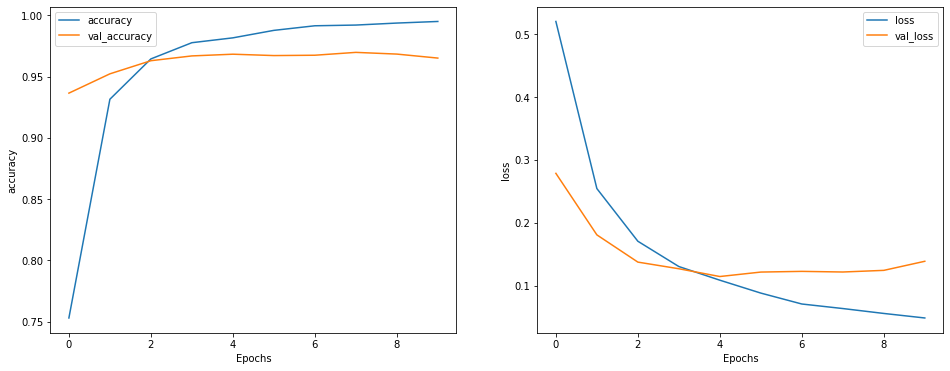

In [15]:
#plot the train/validation loss and accuracy
def plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

<a id = 'evaluate_model'></a>
## 3.3 Evaluate the model

<i><font size = 3.5>For final evaluation we use the separate test set</font></i>

In [16]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

559/559 [==============================] - 18s 32ms/step - loss: 0.1475 - accuracy: 0.9643
Test Loss: 0.14751991629600525
Test Accuracy: 0.9642717242240906


In [17]:
## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      8757
           1       0.97      0.96      0.96      9128

    accuracy                           0.96     17885
   macro avg       0.96      0.96      0.96     17885
weighted avg       0.96      0.96      0.96     17885



Text(51.0, 0.5, 'Real Labels')

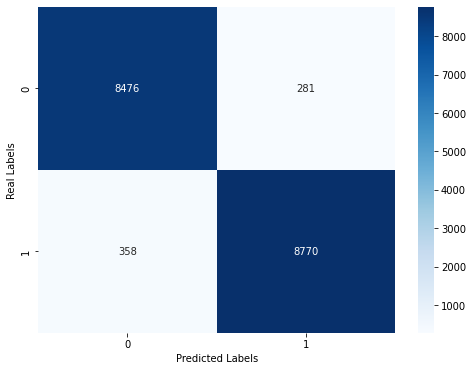

In [18]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

<a id = 'conclusion'></a>
## Conclusion
- <font size = 3.5>The model gives pretty good results with accuracy around 97%</font>
- <font size = 3.5>To use more efficiently the data we can use StratifiedKFold and run 5 or 10 folds of training/validation</font>
- <font size = 3.5>We can test the model performance with longer max sequence length (will increase the memmory usage and computation time)</font>
- <font size = 3.5>Try different LSTM unit size/layer number</font>
- <font size = 3.5>Try different embedding output</font>